<pre><font size=6>Spoken Digit Recognition</font></pre>

<pre>
In this notebook, You will do Spoken Digit Recognition. 

Input - speech signal, output - digit number



It contains  

1. Reading the dataset. and Preprocess the data set. Detailed instrctions are given below. You have to write the code in the same cell which contains the instrction. 
2. Training the LSTM with RAW data
3. Converting to spectrogram and Training the LSTM network
4. Creating the augmented data and doing step 2 and 3 again.  

<font size=5>instructions:</font>

    1. Don't change any Grader Functions. Don't manipulate any Grader functions. If you manipulate any, it will be considered as plagiarised. 
    
    2. Please read the instructions on the code cells and markdown cells. We will explain what to write. 
    
    3. please return outputs in the same format what we asked. Eg. Don't return List of we are asking for a numpy array.
    
    4. Please read the external links that we are given so that you will learn the concept behind the code that you are writing.
    
    5. We are giving instructions at each section if necessary, please follow them. 

<font size=5>Every Grader function has to return True. </font>

</pre>

In [ ]:
import numpy as np
import pandas as pd
import librosa
import os
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
import numpy as np
%load_ext tensorboard
from tensorflow.keras import regularizers
import tensorflow as tf
##if you need any imports you can do that here. 

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


We shared recordings.zip, please unzip those. 

In [ ]:
#read the all file names in the recordings folder given by us
#(if you get entire path, it is very useful in future)
#save those files names as list in "all_files"


In [ ]:
path="/content/drive/My Drive/recordings"
all_files=os.listdir("/content/drive/My Drive/recordings")
files=[i for i in all_files if i.endswith(".wav")]
file_path=[path+"/"+i for i in files]

In [ ]:
labels=[]
for i in files:
  a=int(i.split("_")[0])
  labels.append(a)

<font size=4>Grader function 1 </font>

In [ ]:
def grader_files():
    temp = len(all_files)==2000
    temp1 = all([x[-3:]=="wav" for x in all_files])
    temp = temp and temp1
    return temp
grader_files()

True

Create a dataframe(name=df_audio) with two columns(path, label).   
You can get the label from the first letter of name.  
Eg: 0_jackson_0 --> 0  
0_jackson_43 --> 0

In [ ]:
#Create a dataframe(name=df_audio) with two columns(path, label).   
#You can get the label from the first letter of name.  
#Eg: 0_jackson_0 --> 0  
#0_jackson_43 --> 0


In [ ]:
df_audio=pd.DataFrame({"path":file_path,"label":labels})
df_audio.head()

,path,label
0,/content/drive/My Drive/recordings/1_theo_39.wav,1
1,/content/drive/My Drive/recordings/3_theo_27.wav,3
2,/content/drive/My Drive/recordings/5_nicolas_4...,5
3,/content/drive/My Drive/recordings/9_jackson_4...,9
4,/content/drive/My Drive/recordings/2_theo_9.wav,2


In [ ]:
#info
df_audio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    2000 non-null   object
 1   label   2000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.4+ KB


<font size=4>Grader function 2 </font>

In [ ]:
def grader_df():
    flag_shape = df_audio.shape==(2000,2)
    flag_columns = all(df_audio.columns==['path', 'label'])
    list_values = list(df_audio.label.value_counts())
    flag_label = len(list_values)==10
    flag_label2 = all([i==200 for i in list_values])
    final_flag = flag_shape and flag_columns and flag_label and flag_label2
    return final_flag
grader_df()

True

In [ ]:
from sklearn.utils import shuffle
df_audio = shuffle(df_audio, random_state=33)#don't change the random state

<pre><font size=4>Train and Validation split</font></pre>

In [ ]:
#split the data into train and validation and save in X_train, X_test, y_train, y_test
#use stratify sampling
#use random state of 45
#use test size of 30%


In [ ]:
X=df_audio.drop("label",axis=1)
y=df_audio["label"]
X_train,X_test,y_train,y_test=train_test_split(X,y,stratify=y,random_state=45,test_size=0.3)

In [ ]:
pickle.dump((y_train),open('y_train.pkl','wb'))
pickle.dump((y_test),open('y_test.pkl','wb'))

In [ ]:
y_train=pickle.load(open("/content/drive/My Drive/y_train.pkl", 'rb')) 
y_test=pickle.load(open("/content/drive/My Drive/y_test.pkl","rb"))

<font size=4>Grader function 3 </font>

In [ ]:
def grader_split():
    flag_len = (len(X_train)==1400) and (len(X_test)==600) and (len(y_train)==1400) and (len(y_test)==600)
    values_ytrain = list(y_train.value_counts())
    flag_ytrain = (len(values_ytrain)==10) and (all([i==140 for i in values_ytrain]))
    values_ytest = list(y_test.value_counts())
    flag_ytest = (len(values_ytest)==10) and (all([i==60 for i in values_ytest]))
    final_flag = flag_len and flag_ytrain and flag_ytest
    return final_flag
grader_split()

True

<pre><font size=4>Preprocessing</font>

All files are in the "WAV" format. We will read those raw data files using the librosa</pre>

In [ ]:
sample_rate = 22050
def load_wav(x, get_duration=True):
    '''This return the array values of audio with sampling rate of 22050 and Duration'''
    #loading the wav file with sampling rate of 22050
    samples, sample_rate = librosa.load(x, sr=22050)
    if get_duration:
        duration = librosa.get_duration(samples, sample_rate)
        return samples, duration
    else:
        return samples

In [ ]:
train_durations=[]
for i in range(len(X_train)):
  sample,duration=load_wav(X_train.values[i][0])
  train_durations.append(duration)

In [ ]:
X_train=X_train.rename(columns={"path":"raw_data"})
X_train["duration"]=train_durations
X_train_processed=X_train

In [ ]:
X_train_processed.head()

,raw_data,duration
1265,/content/drive/My Drive/recordings/6_yweweler_...,0.181270
1715,/content/drive/My Drive/recordings/1_theo_12.wav,0.233787
836,/content/drive/My Drive/recordings/6_theo_17.wav,0.597415
1635,/content/drive/My Drive/recordings/5_theo_44.wav,0.413288
576,/content/drive/My Drive/recordings/0_yweweler_...,0.381633


In [ ]:
test_durations=[]
for i in range(len(X_test)):
  sample,duration=load_wav(X_test.values[i][0])
  test_durations.append(duration)

In [ ]:
X_test=X_test.rename(columns={"path":"raw_data"})
X_test["duration"]=test_durations
X_test_processed=X_test

In [ ]:
X_test_processed.head()

,raw_data,duration
1459,/content/drive/My Drive/recordings/3_theo_28.wav,0.385533
1041,/content/drive/My Drive/recordings/5_theo_20.wav,0.303129
1197,/content/drive/My Drive/recordings/2_yweweler_...,0.238277
1107,/content/drive/My Drive/recordings/6_theo_13.wav,0.340136
239,/content/drive/My Drive/recordings/9_theo_41.wav,0.393651


In [ ]:
pickle.dump((X_train_processed),open('X_train_processed.pkl','wb'))
pickle.dump((X_test_processed),open('X_test_processed.pkl','wb'))

In [ ]:
X_train_processed=pickle.load(open("/content/drive/My Drive/X_train_processed.pkl", 'rb')) 
X_test_processed=pickle.load(open("/content/drive/My Drive/X_test_processed.pkl","rb"))

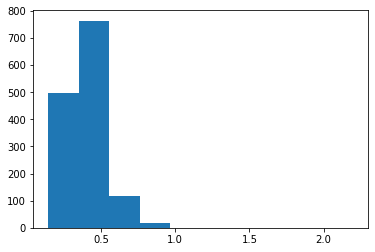

In [ ]:
plt.hist(X_train_processed["duration"])
plt.show()

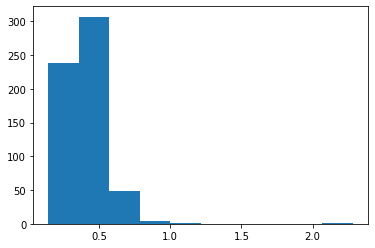

In [ ]:
plt.hist(X_test_processed["duration"])
plt.show()

In [ ]:
for i in range(0,101,10):
  print(i,"th percentile is :",np.percentile(X_train_processed["duration"].values,i))

0 th percentile is : 0.1435374149659864
10 th percentile is : 0.25989569160997733
20 th percentile is : 0.30038095238095236
30 th percentile is : 0.33387755102040817
40 th percentile is : 0.35935600907029475
50 th percentile is : 0.38950113378684803
60 th percentile is : 0.418639455782313
70 th percentile is : 0.4488888888888889
80 th percentile is : 0.48315646258503403
90 th percentile is : 0.5539773242630387
100 th percentile is : 2.195918367346939


In [ ]:
for i in range(90,101):
  print(i,"th percentile is :",np.percentile(X_train_processed["duration"].values,i))

90 th percentile is : 0.5539773242630387
91 th percentile is : 0.5683886621315194
92 th percentile is : 0.5829315192743765
93 th percentile is : 0.6012321995464855
94 th percentile is : 0.6143074829931973
95 th percentile is : 0.6315941043083899
96 th percentile is : 0.6435863945578231
97 th percentile is : 0.6650408163265307
98 th percentile is : 0.6929070294784577
99 th percentile is : 0.79601179138322
100 th percentile is : 2.195918367346939


<font size=4>Grader function 4 </font>

In [ ]:
def grader_processed():
    flag_columns = (all(X_train_processed.columns==['raw_data', 'duration'])) and (all(X_test_processed.columns==['raw_data', 'duration']))
    flag_shape = (X_train_processed.shape ==(1400, 2)) and (X_test_processed.shape==(600,2))
    return flag_columns and flag_shape
grader_processed()

True

<pre>Based on our analysis 99 percentile values are less than 0.8sec so we will limit maximum length of X_train_processed and X_test_processed to 0.8 sec. It is similar to pad_sequence for a text dataset. 

While loading the audio files, we are using sampling rate of 22050 so one sec will give array of length 22050. so, our maximum length is 0.8*22050 = 17640

Pad with Zero if length of sequence is less than 17640 else Truncate the number. 

Also create a masking vector for train and test. 

masking vector value = 1 if it is real value, 0 if it is pad value. Masking vector data type must be bool.
</pre>

In [ ]:
max_length  = 17640

# Train pad sequence and masking

In [ ]:
train_sample=[]
for i in range(len(X_train)):
  sample,duration=load_wav(X_train.values[i][0])
  train_sample.append(sample)

In [ ]:
X_train_pad_seq=[]
for i in train_sample:
  if len(i)==max_length-1:
    X_train_pad_seq.append(i)
  elif len(i)>max_length-1:
    a=i[0:max_length]
    X_train_pad_seq.append(a)
  elif len(i)<max_length-1:
    while len(i)<=max_length-1:
      i=np.append(i,0)
    X_train_pad_seq.append(i)

In [ ]:
X_train_pad_seq=np.array(X_train_pad_seq)
X_train_pad_seq.shape

(1400, 17640)

In [ ]:
X_train_mask=[]
for i in X_train_pad_seq:
  mask=[]
  for j in i:
    if j==0.0:
      mask.append(0)
    else:
      mask.append(1)
  X_train_mask.append(np.array(mask))


In [ ]:
X_train_mask=np.array(X_train_mask)
X_train_mask.shape

(1400, 17640)

In [1]:
import numpy as np
a=np.array([4,5,6,67])
a.shape

(4,)

# Test pad sequence and Masking

In [ ]:
test_sample=[]
for i in range(len(X_test)):
  sample,duration=load_wav(X_test.values[i][0])
  test_sample.append(sample)

In [ ]:
X_test_pad_seq=[]
for i in test_sample:
  if len(i)==max_length-1:
    X_test_pad_seq.append(i)
  elif len(i)>max_length-1:
    a=i[0:max_length]
    X_test_pad_seq.append(a)
  elif len(i)<max_length-1:
    while len(i)<=max_length-1:
      i=np.append(i,0)
    X_test_pad_seq.append(i)

In [ ]:
X_test_pad_seq=np.array(X_test_pad_seq)
X_test_pad_seq.shape

(600, 17640)

In [ ]:
X_test_mask=[]
for i in X_test_pad_seq:
  mask=[]
  for j in i:
    if j==0.0:
      mask.append(0)
    else:
      mask.append(1)
  X_test_mask.append(np.array(mask))

In [ ]:
X_test_mask=np.array(X_test_mask,dtype=bool)
X_test_mask.shape

(600, 17640)

In [ ]:
pickle.dump((X_train_pad_seq),open('X_train_pad_seq.pkl','wb'))
pickle.dump((X_test_pad_seq),open('X_test_pad_seq.pkl','wb'))

In [ ]:
X_train_pad_seq=pickle.load(open("/content/drive/My Drive/X_train_pad_seq.pkl", 'rb')) 
X_test_pad_seq=pickle.load(open("/content/drive/My Drive/X_test_pad_seq.pkl","rb"))

In [ ]:
pickle.dump((X_train_mask),open('X_train_mask.pkl','wb'))
pickle.dump((X_test_mask),open('X_test_mask.pkl','wb'))

In [ ]:
X_train_mask=pickle.load(open("/content/drive/My Drive/X_train_mask.pkl", 'rb')) 
X_test_mask=pickle.load(open("/content/drive/My Drive/X_test_mask.pkl","rb"))

In [ ]:
X_train_mask=np.array(X_train_mask,dtype=bool)
X_test_mask=np.array(X_test_mask,dtype=bool)

In [ ]:
## as discussed above, Pad with Zero if length of sequence is less than 17640 else Truncate the number. 
## save in the X_train_pad_seq, X_test_pad_seq
## also Create masking vector X_train_mask, X_test_mask

## all the X_train_pad_seq, X_test_pad_seq, X_train_mask, X_test_mask will be numpy arrays mask vector dtype must be bool.

<font size=4>Grader function 5 </font>

In [ ]:
def grader_padoutput():
    flag_padshape = (X_train_pad_seq.shape==(1400, 17640)) and (X_test_pad_seq.shape==(600, 17640)) and (y_train.shape==(1400,))
    flag_maskshape = (X_train_mask.shape==(1400, 17640)) and (X_test_mask.shape==(600, 17640)) and (y_test.shape==(600,))
    flag_dtype = (X_train_mask.dtype==bool) and (X_test_mask.dtype==bool)
    return flag_padshape and flag_maskshape and flag_dtype
grader_padoutput()

True

### 1. Giving Raw data directly. 

<pre>
Now we have

Train data: X_train_pad_seq, X_train_mask and y_train  
Test data: X_test_pad_seq, X_test_mask and y_test   

We will create a LSTM model which takes this input. 

Task:

1. Create an LSTM network which takes "X_train_pad_seq" as input, "X_train_mask" as mask input. You can use any number of LSTM cells. Please read LSTM documentation(https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) in tensorflow to know more about mask and also https://www.tensorflow.org/guide/keras/masking_and_padding 
2. Get the final output of the LSTM and give it to Dense layer of any size and then give it to Dense layer of size 10(because we have 10 outputs) and then compile with the sparse categorical cross entropy( because we are not converting it to one hot vectors). 
3. Use tensorboard to plot the graphs of loss and metric(use micro F1 score as metric) and histograms of gradients. 
4. make sure that it won't overfit. 
5. You are free to include any regularization
</pre>

# The model 1 architecture and training is done in (dhilipvasanth@gmail.com (model 1 and model 2 training).ipynb)

kindly plse check with that notebook sir due to crash of RAM in colab i did in parallel way.



### 2. Converting into spectrogram and giving spectrogram data as input  
<pre>
We can use librosa to convert raw data into spectrogram. A spectrogram shows the features in a two-dimensional representation with the
intensity of a frequency at a point in time i.e we are converting Time domain to frequency domain. you can read more about this in https://pnsn.org/spectrograms/what-is-a-spectrogram
</pre>

In [ ]:
sample_rate = 22050
def convert_to_spectrogram(raw_data):
    '''converting to spectrogram'''
    spectrum = librosa.feature.melspectrogram(y=raw_data, sr=sample_rate, n_mels=64)
    logmel_spectrum = librosa.power_to_db(S=spectrum, ref=np.max)
    return logmel_spectrum

In [ ]:
X_train_spectrogram=[]
for i in X_train_pad_seq:
  a=convert_to_spectrogram(i)
  X_train_spectrogram.append(a)

In [ ]:
X_train_spectrogram=np.array(X_train_spectrogram)
X_train_spectrogram.shape

(1400, 64, 35)

In [ ]:
X_test_spectrogram=[]
for i in X_test_pad_seq:
  a=convert_to_spectrogram(i)
  X_test_spectrogram.append(a)

In [ ]:
X_test_spectrogram=np.array(X_test_spectrogram)
X_test_spectrogram.shape

(600, 64, 35)

<font size=4>Grader function 6 </font>

In [ ]:
def grader_spectrogram():
    flag_shape = (X_train_spectrogram.shape==(1400,64, 35)) and (X_test_spectrogram.shape == (600, 64, 35))
    return flag_shape
grader_spectrogram()

True

<pre>
Now we have

Train data: X_train_spectrogram and y_train  
Test data: X_test_spectrogram and y_test   

We will create a LSTM model which takes this input. 

Task:

1. Create an LSTM network which takes "X_train_spectrogram" as input and has to return output at every time step. 
2. Average the output of every time step and give this to the Dense layer of any size. 
3. give the above output to Dense layer of size 10( output layer) and train the network with sparse categorical cross entropy.  
4. Use tensorboard to plot the graphs of loss and metric(use micro F1 score as metric) and histograms of gradients. 
5. make sure that it won't overfit. 
6. You are free to include any regularization
</pre>

# The model 2 architecture and training is done in (dhilipvasanth@gmail.com (model 1 and model 2 training).ipynb)

kindly plse check with that notebook sir due to crash of RAM in colab i did in parallel way.



### 3. data augmentation  
<pre>
Till now we have done with 2000 samples only. It is very less data. We are giving the process of generating augmented data below.

There are two types of augmentation:
1. time stretching - Time stretching either increases or decreases the length of the file. For time stretching we move the file 30% faster or slower
2. pitch shifting - pitch shifting moves the frequencies higher or lower. For pitch shifting we shift up or down one half-step.
</pre>

In [ ]:
sample_rate = 22050
import glob
import librosa
audiofiles=glob.glob("/content/drive/My Drive/recordings/*.wav")
sample=[]
for i in audiofiles:
  sample.append(load_wav(i)[0])

In [ ]:
augmented_data = []
for i in sample:
  for time_value in [0.7, 1, 1.3]:
    for pitch_value in [-1, 0, 1]:
        time_stretch_data = librosa.effects.time_stretch(i, rate=time_value)
        final_data = librosa.effects.pitch_shift(time_stretch_data, sr=sample_rate, n_steps=pitch_value)
        augmented_data.append(final_data)

In [ ]:
import itertools
label=[]
for i in df_audio.label:
  label.append(i)
class_label=list(itertools.chain.from_iterable(itertools.repeat(x, 9) for x in label)) 

# Augmented DataFrame

In [ ]:
aug_data=pd.DataFrame({"data":augmented_data,"labels":class_label})
aug_data.head()

,data,labels
0,"[3.2366613e-06, 1.0926803e-05, 5.532477e-06, -...",1
1,"[-1.4128769e-05, -2.0117726e-05, -4.030403e-05...",1
2,"[-1.4320675e-05, -2.0050189e-05, -4.102338e-05...",1
3,"[-1.1168399e-05, -1.0668543e-05, -1.5301881e-0...",1
4,"[-1.933556e-05, -2.3912407e-05, -3.537483e-05,...",1


As discussed above, for one data point, we will get 9 augmented data points.  
We have 2000 data points(train plus test) so, after augmentation we will get 18000 ( train - 12600, test - 5400). 

do the above steps i.e training with raw data and spectrogram data with augmentation.

## Train Test Split

In [ ]:
x=aug_data.drop("labels",axis=1)
y=aug_data["labels"]
X_train1,X_test1,y_train1,y_test1=train_test_split(x,y,stratify=y,random_state=45,test_size=0.3)

In [ ]:
pickle.dump((X_train1),open('x_train1.pkl','wb'))
pickle.dump((X_test1),open('x_test1.pkl','wb'))

In [ ]:
xtrain1=pickle.load(open("/content/drive/My Drive/x_train1.pkl", 'rb'))
xtest1=pickle.load(open("/content/drive/My Drive/x_test1.pkl", 'rb'))

In [ ]:
pickle.dump((y_train1),open('y_train1.pkl','wb'))
pickle.dump((y_test1),open('y_test1.pkl','wb'))

In [ ]:
ytrain1=pickle.load(open("/content/drive/My Drive/y_train1.pkl", 'rb'))
ytest1=pickle.load(open("/content/drive/My Drive/y_test1.pkl", 'rb'))

In [ ]:
print(xtrain1.shape)
print(xtest1.shape)

(12600, 1)
(5400, 1)


## Raw Data model

# Train pad sequence and masking

In [ ]:
max_length=17640
X_train_pad_seq=[]
for i in xtrain1.values.flatten():
  if len(i)==max_length-1:
    X_train_pad_seq.append(i)
  elif len(i)>max_length-1:
    a=i[0:max_length]
    X_train_pad_seq.append(a)
  elif len(i)<max_length-1:
    while len(i)<=max_length-1:
      i=np.append(i,0)
    X_train_pad_seq.append(i)

In [ ]:
X_train_pad_seq1=np.array(X_train_pad_seq)
X_train_pad_seq1.shape

(12600, 17640)

In [ ]:
pickle.dump((X_train_pad_seq1),open('X_train_pad_seq1.pkl','wb'))

In [ ]:
X_train_pad_seq1=pickle.load(open("/content/drive/My Drive/X_train_pad_seq1.pkl", 'rb'))

In [ ]:
X_train_pad_seq1.shape

(12600, 17640)

In [ ]:
X_train_mask=[]
for i in X_train_pad_seq1:
  mask=[]
  for j in i:
    if j==0.0:
      mask.append(0)
    else:
      mask.append(1)
  X_train_mask.append(np.array(mask))

In [ ]:
X_train_mask1=np.array(X_train_mask)
X_train_mask1.shape

(12600, 17640)

In [ ]:
pickle.dump((X_train_mask1),open('X_train_mask1.pkl','wb'))

In [ ]:
X_train_mask1=pickle.load(open("/content/drive/My Drive/X_train_mask1.pkl", 'rb')) 

In [ ]:
X_train_mask1.shape

(12600, 17640)

# Test pad sequence and masking

In [ ]:
X_test_pad_seq=[]
for i in X_test1.values.flatten():
  if len(i)==max_length-1:
    X_test_pad_seq.append(i)
  elif len(i)>max_length-1:
    a=i[0:max_length]
    X_test_pad_seq.append(a)
  elif len(i)<max_length-1:
    while len(i)<=max_length-1:
      i=np.append(i,0)
    X_test_pad_seq.append(i)

In [ ]:
X_test_mask=[]
for i in X_test_pad_seq1:
  mask=[]
  for j in i:
    if j==0.0:
      mask.append(0)
    else:
      mask.append(1)
  X_test_mask.append(np.array(mask))

In [ ]:
X_test_mask1=np.array(X_train_mask)
X_test_mask1.shape

In [ ]:
pickle.dump((X_test_pad_seq1),open('X_test_pad_seq1.pkl','wb'))
pickle.dump((x_test_mask1),open('X_test_mask1.pkl','wb'))

In [ ]:
X_test_pad_seq1=pickle.load(open("/content/drive/My Drive/X_test_pad_seq1.pkl","rb"))
X_test_mask1=pickle.load(open("/content/drive/My Drive/X_test_mask1.pkl","rb"))

In [ ]:
X_test_mask1.shape

(5400, 17640)

In [ ]:
X_test_pad_seq1.shape

(5400, 17640)

# Model 3 architecture and training is done in (dhilipvasanth@gmail.com(model3 and model 4 training.ipynb) files

Due to crash of Ram in colab i did my model training in paralel.

# Augmented Spectrogram Input

Train spectrogram data

In [ ]:
sample_rate = 22050
def convert_to_spectrogram(raw_data):
    '''converting to spectrogram'''
    spectrum = librosa.feature.melspectrogram(y=raw_data, sr=sample_rate, n_mels=64)
    logmel_spectrum = librosa.power_to_db(S=spectrum, ref=np.max)
    return logmel_spectrum

In [ ]:
X_train_spectrogram=[]
for i in X_train_pad_seq1:
  a=convert_to_spectrogram(i)
  X_train_spectrogram.append(a)
X_train_spectrogram1=np.array(X_train_spectrogram)

In [ ]:
pickle.dump((X_train_spectrogram1),open('/content/drive/My Drive/X_train_spectrogram1.pkl','wb'))

In [ ]:
X_train_spectrogram1=pickle.load(open("/content/drive/My Drive/X_train_spectrogram1.pkl","rb"))
X_train_spectrogram1.shape

(12600, 64, 35)

Test spectrogram data

In [ ]:
X_test_spectrogram=[]
for i in X_test_pad_seq1:
  a=convert_to_spectrogram(i)
  X_test_spectrogram.append(a)

In [ ]:
X_test_spectrogram1=np.array(X_test_spectrogram)

In [ ]:
pickle.dump((X_test_spectrogram1),open('/content/drive/My Drive/X_test_spectrogram1.pkl','wb'))

In [ ]:
X_test_spectrogram1=pickle.load(open("/content/drive/My Drive/X_test_spectrogram1.pkl","rb"))
X_test_spectrogram1.shape

(5400, 64, 35)

# Model 4 architecture and training is done in (dhilipvasanth@gmail.com(model3 and model 4 training.ipynb) files
Due to crash of Ram in colab i did my model training in paralel.